# **Predicting gender with ensemble learning approach**


![](https://scx2.b-cdn.net/gfx/news/hires/2018/gender.jpg)

# ***== Data reading & cleaning ==***

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/drive/MyDrive/DataScience/Classification/Gender Classification/gender_classification_v7.csv')
print(data.shape)
data.head()

(5001, 8)


,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


In [3]:
# Encode the 'gender' variable: 0 for 'Male & 1 for 'Female'
code = {'Male':0, 'Female':1}
data['gender'] = data['gender'].map(code)
data.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,0
1,0,14.0,5.4,0,0,1,0,1
2,0,11.8,6.3,1,1,1,1,0
3,0,14.4,6.1,0,1,1,1,0
4,1,13.5,5.9,0,0,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 312.7 KB


As can be observed, most of the features are actually categorical, only 'forehead_width_cm' and 'forehead_height_cm' are numerical. 

In [5]:
# Turn the features into the right data type
categories = [i for i in data.columns if data[i].dtype == 'int64']
for i in categories:
  data[i] = data[i].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   long_hair                  5001 non-null   category
 1   forehead_width_cm          5001 non-null   float64 
 2   forehead_height_cm         5001 non-null   float64 
 3   nose_wide                  5001 non-null   category
 4   nose_long                  5001 non-null   category
 5   lips_thin                  5001 non-null   category
 6   distance_nose_to_lip_long  5001 non-null   category
 7   gender                     5001 non-null   category
dtypes: category(6), float64(2)
memory usage: 108.1 KB


In [6]:
# Investigate the number of unique values in each column
for i in data.columns:
  print(f'The column "{i}" has {len(data[i].value_counts())} unique values.')

The column "long_hair" has 2 unique values.
The column "forehead_width_cm" has 42 unique values.
The column "forehead_height_cm" has 21 unique values.
The column "nose_wide" has 2 unique values.
The column "nose_long" has 2 unique values.
The column "lips_thin" has 2 unique values.
The column "distance_nose_to_lip_long" has 2 unique values.
The column "gender" has 2 unique values.


# ***== Exploratory data analysis (EDA) ==***

1    2501
0    2500
Name: gender, dtype: int64


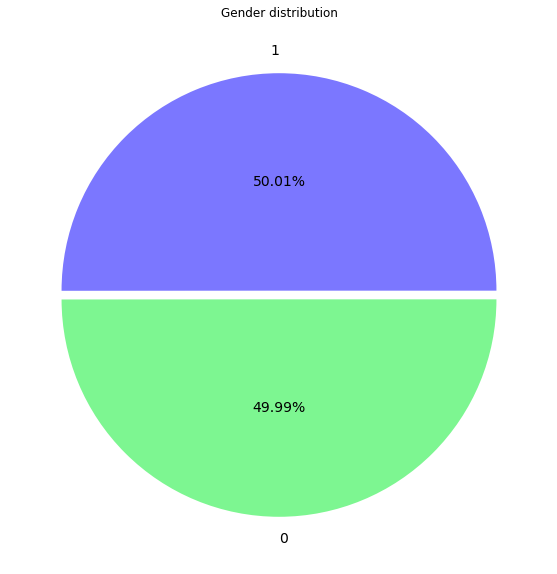

In [7]:
print(data['gender'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = [1, 0]
colors = ['#7b77ff', '#7df691']
plt.pie(x = data['gender'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Gender distribution')
plt.show()

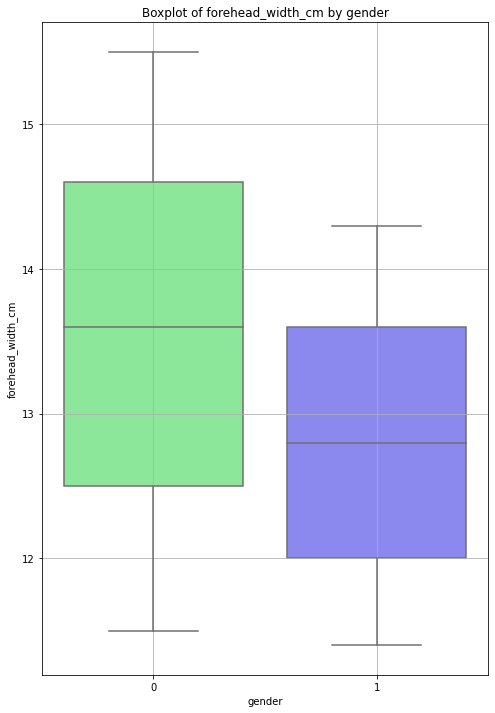

In [8]:
plt.figure(figsize=(8,12))
my_pall={1:'#7b77ff', 0:'#7df691'}
sns.boxplot(x='gender', y="forehead_width_cm", data=data, palette=my_pall)
plt.title('Boxplot of forehead_width_cm by gender')
plt.grid()
plt.show()

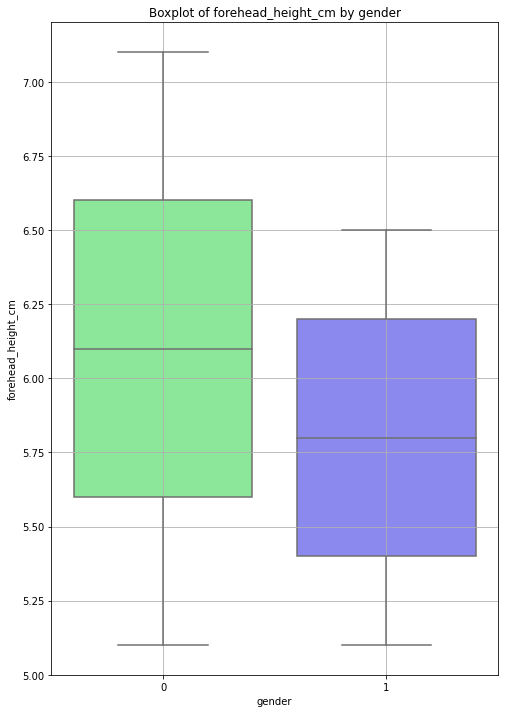

In [9]:
plt.figure(figsize=(8,12))
my_pall={1:'#7b77ff', 0:'#7df691'}
sns.boxplot(x='gender', y="forehead_height_cm", data=data, palette=my_pall)
plt.title('Boxplot of forehead_height_cm by gender')
plt.grid()
plt.show()

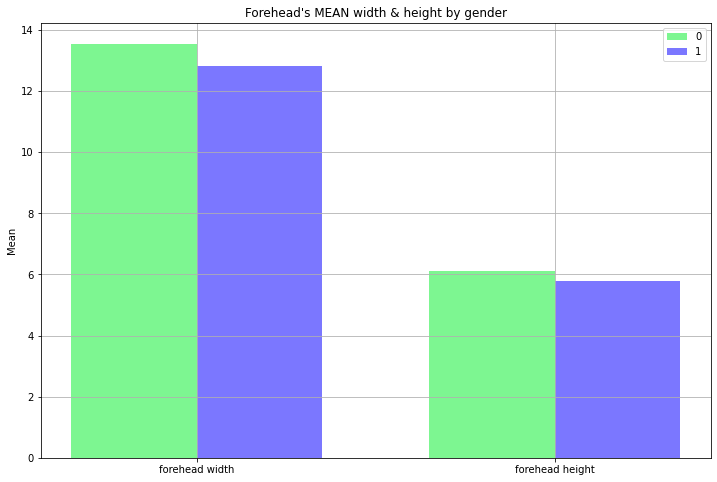

In [10]:
genders_diff = data.groupby('gender')[['forehead_width_cm','forehead_height_cm' ]].mean()

labels = ['forehead width', 'forehead height']
m_means =[genders_diff.iloc[0, 0], genders_diff.iloc[0,1]]
f_means = [genders_diff.iloc[1, 0], genders_diff.iloc[1,1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, m_means, width, label='0', color = '#7df691')
rects2 = ax.bar(x + width/2, f_means, width, label='1', color = '#7b77ff')


ax.set_ylabel('Mean')
ax.set_title("Forehead's MEAN width & height by gender")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid()
plt.show()

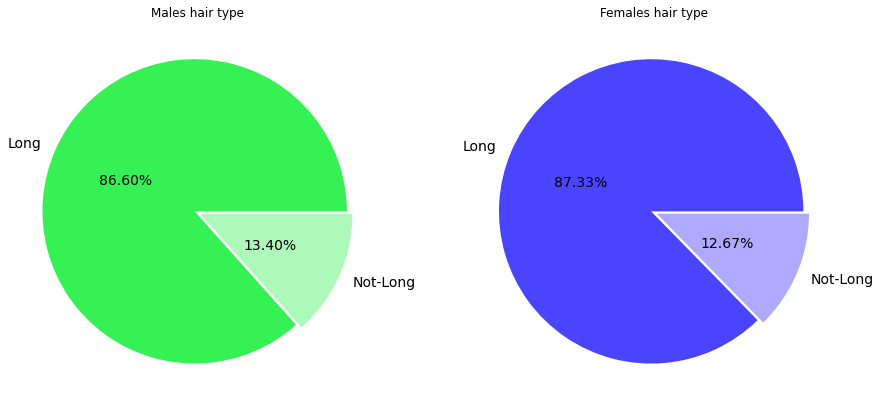

In [11]:
males = data[data['gender'] == 0]
females = data[data['gender'] == 1]
# HAIR comparison
pie, ax = plt.subplots(1,2, figsize=[15,10])
labels = ['Long', 'Not-Long']
colors_m = ['#35f154', '#adf9b9']
colors_f = ['#4a44ff', '#adaaff']
ax[0].pie(x = males['long_hair'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_m)
ax[0].set_title('Males hair type')
ax[1].pie(x = females['long_hair'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_f)
ax[1].set_title('Females hair type')
plt.show()

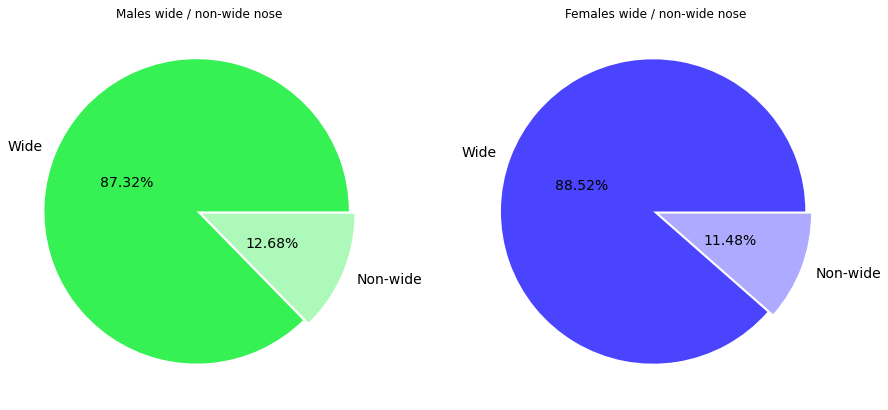

In [12]:
# NOSE WIDE comparison
pie, ax = plt.subplots(1,2, figsize=[15,10])
labels = ['Wide', 'Non-wide']
colors_m = ['#35f154', '#adf9b9']
colors_f = ['#4a44ff', '#adaaff']
ax[0].pie(x = males['nose_wide'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_m)
ax[0].set_title('Males wide / non-wide nose')
ax[1].pie(x = females['nose_wide'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_f)
ax[1].set_title('Females wide / non-wide nose')
plt.show()

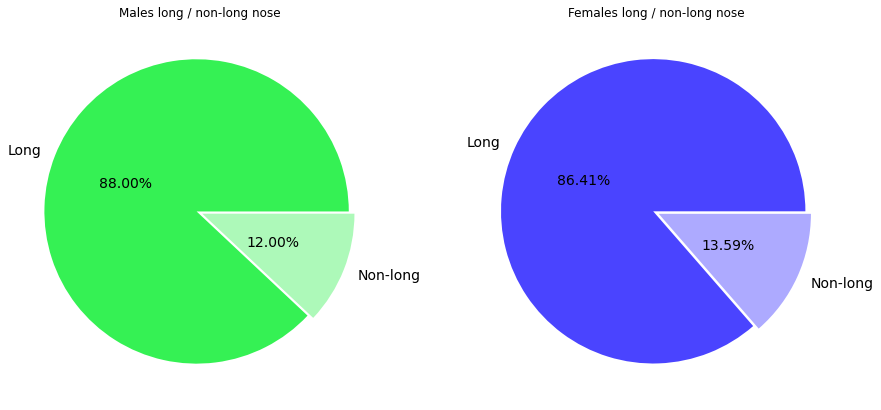

In [13]:
# NOSE LONG comparison 
pie, ax = plt.subplots(1,2, figsize=[15,10])
labels = ['Long', 'Non-long']
colors_m = ['#35f154', '#adf9b9']
colors_f = ['#4a44ff', '#adaaff']
ax[0].pie(x = males['nose_long'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_m)
ax[0].set_title('Males long / non-long nose')
ax[1].pie(x = females['nose_long'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_f)
ax[1].set_title('Females long / non-long nose')
plt.show()

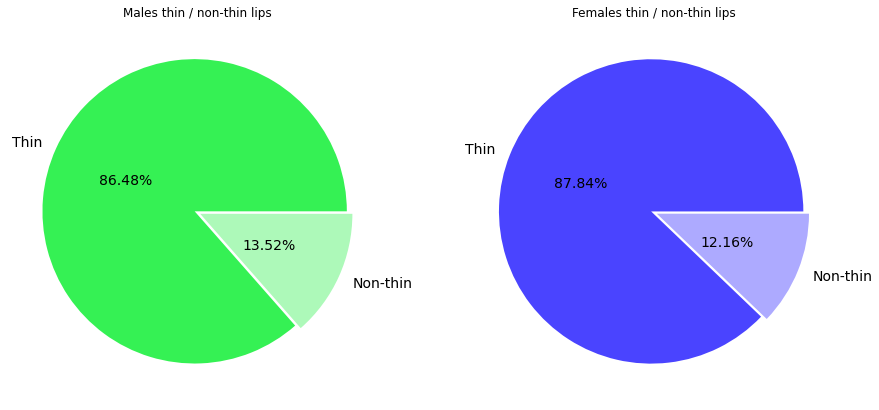

In [14]:
# LIPS comparison
pie, ax = plt.subplots(1,2, figsize=[15,10])
labels = ['Thin', 'Non-thin']
colors_m = ['#35f154', '#adf9b9']
colors_f = ['#4a44ff', '#adaaff']
ax[0].pie(x = males['lips_thin'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_m)
ax[0].set_title('Males thin / non-thin lips')
ax[1].pie(x = females['lips_thin'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_f)
ax[1].set_title('Females thin / non-thin lips')
plt.show()

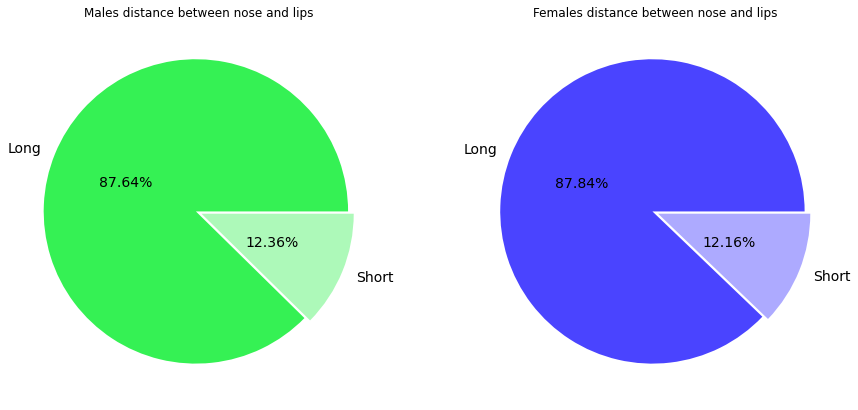

In [15]:
# LIPS-NOSE distance comparison
pie, ax = plt.subplots(1,2, figsize=[15,10])
labels = ['Long', 'Short']
colors_m = ['#35f154', '#adf9b9']
colors_f = ['#4a44ff', '#adaaff']
ax[0].pie(x = males['distance_nose_to_lip_long'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_m)
ax[0].set_title('Males distance between nose and lips')
ax[1].pie(x = females['distance_nose_to_lip_long'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors_f)
ax[1].set_title('Females distance between nose and lips')
plt.show()

# ***== Data preparation ==***

In [16]:
# Separate features and target
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

# Split them into training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 123, shuffle = True, stratify = target)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 7) (4000,)
(1001, 7) (1001,)


# ***== Modelling ==***

## Initialize classifiers and hyperparameters

In [36]:
# Initiate classifiers
LR = LogisticRegression()
SGDC = SGDClassifier()
SVC = SVC()
KNN = KNeighborsClassifier()
DT = DecisionTreeClassifier()

# Initiate hyperparameters for classifiers
param_LR = {'C':[0.01, 0.1, 1, 10], 'penalty':['l1', 'l2']}
param_SGDC = {'alpha':[0.01, 0.1, 1, 10], 'loss':['hinge', 'log'], 'penalty':['l1', 'l2']}
param_SVC = {'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1, 10]}
param_KNN = {'n_neighbors':[2,3,4,5,6]}
param_DT = {'criterion':['gini', 'entropy'], 'max_depth': [3,4,5,6], 'min_samples_leaf':[0.1, 0.5, 1, 1.5, 2]}

## Hyperparameters tuning

In [39]:
# Logistic egression
search_LR = GridSearchCV(LR, param_LR)
search_LR.fit(X_train, y_train)
print(f'Best CV params {search_LR.best_params_}')
print(f'Best CV accuracy {search_LR.best_score_}')
print(f'Test accuracy of best hypers {search_LR.score(X_test, y_test)}')

Best CV params {'C': 0.1, 'penalty': 'l2'}
Best CV accuracy 0.9712500000000001
Test accuracy of best hypers 0.957042957042957


In [40]:
# SGDClassifier
search_SGDC = GridSearchCV(SGDC, param_SGDC)
search_SGDC.fit(X_train, y_train)
print(f'Best CV params {search_SGDC.best_params_}')
print(f'Best CV accuracy {search_SGDC.best_score_}')
print(f'Test accuracy of best hypers {search_SGDC.score(X_test, y_test)}')

Best CV params {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l2'}
Best CV accuracy 0.9695
Test accuracy of best hypers 0.962037962037962


In [41]:
# SVC
search_SVC = GridSearchCV(SVC, param_SVC)
search_SVC.fit(X_train, y_train)
print(f'Best CV params {search_SVC.best_params_}')
print(f'Best CV accuracy {search_SVC.best_score_}')
print(f'Test accuracy of best hypers {search_SVC.score(X_test, y_test)}')

Best CV params {'C': 10, 'gamma': 0.1}
Best CV accuracy 0.97625
Test accuracy of best hypers 0.9660339660339661


In [42]:
# KNN
search_KNN = GridSearchCV(KNN, param_KNN)
search_KNN.fit(X_train, y_train)
print(f'Best CV params {search_KNN.best_params_}')
print(f'Best CV accuracy {search_KNN.best_score_}')
print(f'Test accuracy of best hypers {search_KNN.score(X_test, y_test)}')

Best CV params {'n_neighbors': 5}
Best CV accuracy 0.96875
Test accuracy of best hypers 0.962037962037962


In [44]:
# DecisionTree
search_DT = GridSearchCV(DT, param_DT)
search_DT.fit(X_train, y_train)
print(f'Best CV params {search_DT.best_params_}')
print(f'Best CV accuracy {search_DT.best_score_}')
print(f'Test accuracy of best hypers {search_DT.score(X_test, y_test)}')

Best CV params {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2}
Best CV accuracy 0.97325
Test accuracy of best hypers 0.973026973026973


## Ensemble Learning

In [54]:
from sklearn.svm import SVC

# Re-initiate the models with their best hyperparameters
LR = LogisticRegression(C=0.1, penalty='l2')
SGDC = SGDClassifier(alpha=0.01, loss='hinge', penalty='l2')
SVC = SVC(C=10, gamma=0.1)
KNN = KNeighborsClassifier(n_neighbors=5)
DT = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=2)

# Define a list with tuples that contains classifier's name & classifier
classifiers = [('Logistic Regression', LR),
               ('SGDClassifier', SGDC),
               ('SVC', SVC),
               ('KNN', KNN),
               ('Decision Tree', DT)]

In [55]:
for c_name, c in classifiers:
  c.fit(X_train, y_train)
  preds = c.predict(X_test)
  print(f'{c_name} accuracy: {accuracy_score(y_test, preds)}')

Logistic Regression: 0.957042957042957
SGDClassifier: 0.962037962037962
SVC: 0.9660339660339661
KNN: 0.962037962037962
Decision Tree: 0.973026973026973


In [56]:
# Initiate Voting Classifier
VC = VotingClassifier(estimators=classifiers)
VC.fit(X_train, y_train)
preds = VC.predict(X_test)
print(f'Voting Classifier score: {accuracy_score(y_test, preds)}')

Voting Classifier score: 0.971028971028971


Using the ensemble learning, the accuracy was not improved.

The best performancce was achieved by the DecisionTreeClassifier.

In [60]:
DT.fit(X_train, y_train)
preds = DT.predict(X_test)
confusion_matrix(y_test, preds)

array([[479,  21],
       [  6, 495]])

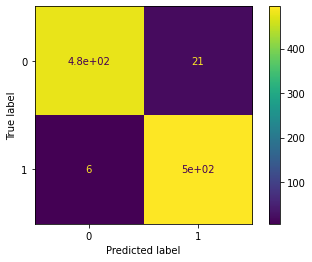

In [61]:
plot_confusion_matrix(DT, X_test, y_test)

Out of 1001 samples, the DecisionTree missclassified 27.


In [62]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       500
           1       0.96      0.99      0.97       501

    accuracy                           0.97      1001
   macro avg       0.97      0.97      0.97      1001
weighted avg       0.97      0.97      0.97      1001



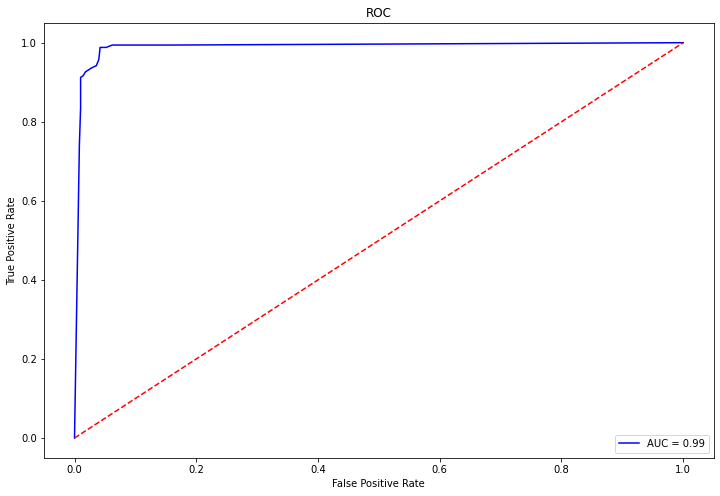

In [63]:
probs = DT.predict_proba(X_test)
pred = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()